In [1]:
# essential libraries
import os
import math
import random
from datetime import timedelta
from datetime import datetime as dt

# storing and anaysis
import numpy as np
import pandas as pd

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import calmap # 설치
import folium # 설치

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

#한글깨짐 방지(0420)
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

#pandas와 같이 plotly에서도 간단한 시각화 지원
import cufflinks as cf
cf.go_offline(connected=True)

# for offline ploting
# ===================
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [2]:
# color pallette
cnf, dth, rec, act = '#393e46', '#ff2e63', '#21bf73', '#fe9801' 
DEFAULT_PLOTLY_COLORS=['rgb(31, 119, 180)', 'rgb(255, 127, 14)',
                       'rgb(44, 160, 44)', 'rgb(214, 39, 40)',
                       'rgb(148, 103, 189)', 'rgb(140, 86, 75)',
                       'rgb(227, 119, 194)', 'rgb(127, 127, 127)',
                       'rgb(188, 189, 34)', 'rgb(23, 190, 207)']

In [3]:
path = '../covid'

In [4]:
os.chdir('data')
file_name_list = os.listdir()
file_name_list

['Case.csv',
 'PatientInfo.csv',
 'PatientRoute.csv',
 'Region.csv',
 'SearchTrend.csv',
 'SeoulFloating.csv',
 'Time.csv',
 'TimeAge.csv',
 'TimeGender.csv',
 'TimeProvince.csv',
 'Weather.csv']

# Time Related Data

### 시간의 흐름에 따른 EDA

- 1.1) 시간에 따른 환자 
- 1.2) 검사자 수와 음성판정자 수
- 1.3) 일단위 확진자 수

- 2.1) 연령별 확진자 
- 2.2) 연령별 사망자 
- 2.3) 성별 확진자 및 사망자 수

- 3.1) 지역별 확진자 추이
- 3.2) 지역별 확진자 추이 상세
- 3.2) 지역별 사망률

In [5]:
time = pd.read_csv('Time.csv')
timeAge = pd.read_csv('timeAge.csv')
timeGender = pd.read_csv('timeGender.csv')
timeProvince = pd.read_csv('TimeProvince.csv',)

In [6]:
layout_setting = {'xaxis_title':'Month','yaxis_title':'Number','font':dict(size=18,color='#60606e',family='Franklin Gothic' )}

## 1.1) 시간에 따른 환자 추이

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=time['date'],y=time['released'],
             mode='lines+markers', name='released'))
fig.add_trace(go.Scatter(x=time['date'],y=time['confirmed'],
             mode='lines+markers', name='confirmed'))
fig.add_trace(go.Scatter(x=time['date'],y=time['deceased'],
             mode='lines+markers', name='deceased'))

fig.update_layout(title='<b>시간에 따른 확진자 추이</b>', **layout_setting)
fig.show()

* 확진자가 급속하게 먼저 늘어나고 이후 완치자 숫자가 크게 증가하고 있습니다.
* 확진자 증가 속도가 감소하면서 전체적인 숫자가 줄어드는 것을 확인할 수 있습니다.

## 1.2) 검사자 수와 음성판정 수

In [8]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(x=time['date'],y=time['negative'],
             mode='lines+markers', name='Negative'))
fig.add_trace(go.Scatter(x=time['date'],y=time['test'],
             mode='lines+markers', name='Test'))

fig.update_layout(title='<b>검사자 수와 음성판정자 수</b>', **layout_setting)
fig.show()

## 1.3) 일단위 확진자 수

* <b>Covid 바이러스 발생 및 확진 날짜</b>
 - 우한 바이러스 첫등장 11월14일
 - 우한지역 첫 확진자 발생 12월1일
 - 국내 첫 확진자 1월 21일
 - 대구 신천지 첫 확진자 2월17일 (31번)
     - 대구 확진 이후를 중점적 확인 필요

In [9]:
time['date'] = pd.to_datetime(time['date'])
start = dt.strptime('2020-02-17', '%Y-%m-%d')
mid = dt.strptime('2020-03-05', '%Y-%m-%d')

fig = go.Figure()
clr = [DEFAULT_PLOTLY_COLORS[3] if start <= d <= mid else DEFAULT_PLOTLY_COLORS[7] for d in time['date']]
fig.add_trace(go.Bar(x=time['date'],y=time['confirmed'].diff(), 
                     name='confirmed', marker=dict(color=clr)))

fig.update_layout(title='<b>일단위 확진자 수</b>',**layout_setting)

fig.show()

## 2.1) 연령별 확진자 

In [10]:
fig = px.bar(timeAge, x='date', y='confirmed',
             hover_data=['age'], color='age', )

fig.update_layout(title='<b>연령별 확진자 추이</b>', **layout_setting)
fig.show()

* 확진자 수는 20대가 훨씬 많다는 것을 알 수 있습니다. 
* 50대가 두번째로 많은 확진자 연령층 입니다.
* 70, 80대 확진자 수 자체는 매우 많지 않다는 것을 알 수 있습니다.

## 2.2) 연령별 사망자 

In [11]:
timeAge_Date = timeAge.pivot_table(index = ['date'],columns=['age'], aggfunc=sum)
timeAge_Date['deceased']

fig = go.Figure()
for col in timeAge_Date['deceased'].columns:
    fig.add_trace(go.Scatter(x=timeAge_Date.index,y= timeAge_Date['deceased'][col],
                 mode='lines+markers', name=col))
# ... #
fig.update_layout(title='<b>연령별 사망자 추이</b>', **layout_setting)
fig.show()

* 20대가 확진자 수가 월등히 많음에도 사망자 숫자 자체가 80, 70대에서 더 많은 것은 나이에 따른 사망확률이 매우 높음을 알 수 있습니다.

## 2.3) 성별 확진자 및 사망자 수

In [12]:
Gender_Date = timeGender.pivot_table(index = ['date'],columns=['sex'], aggfunc=sum)
Gender_Confirmed = Gender_Date['confirmed']
Gender_Deceased = Gender_Date['deceased']

ax3 = px.line(Gender_Confirmed, x=Gender_Confirmed.index, y=Gender_Deceased['female'],
             color_discrete_sequence=['#ff0d5f'], labels='Female')
ax4 = px.line(Gender_Confirmed, x=Gender_Confirmed.index, y=Gender_Deceased['male'],
             color_discrete_sequence=['#3370ff'], labels='Male')

fig = make_subplots(rows=1, cols=2,
                    horizontal_spacing= 0.15,
                   subplot_titles=('<b>남여 확진자 수</b>','<b>남여 사망자 수</b>'))

fig.add_trace(go.Scatter(x=Gender_Confirmed.index, y=Gender_Confirmed['male'],
                 mode='lines', name="Male"), row=1, col=1)
fig.add_trace(go.Scatter(x=Gender_Confirmed.index, y=Gender_Confirmed['female'],
                 mode='lines', name="Female"), row=1, col=1)

fig.add_trace(go.Scatter(x=Gender_Deceased.index, y=Gender_Deceased['male'],
                 mode='lines', name="Male", showlegend=False, line=dict(color='#3370ff')), row=1, col=2)
fig.add_trace(go.Scatter(x=Gender_Deceased.index, y=Gender_Deceased['female'],
                 mode='lines', name="Female", showlegend=False, line=dict(color='#ff0d5f')), row=1, col=2)

fig.update_layout(title='<b>성별 확진자 및 사망자 수</b>', font = layout_setting['font'], showlegend=True)

fig.update_xaxes(title_text="Month", row=1, col=1)
fig.update_xaxes(title_text="Month", row=1, col=2)
fig.update_yaxes(title_text="Number", row=1, col=1)
fig.update_yaxes(title_text="Number", row=1, col=2)

for i in fig['layout']['annotations']:
    i['font'] = dict(size=18)
    
fig.show()

* 여성 확진자 수가 약 1.5배 정도로 많은 반면, 사망자 수는 크게 차이나지 않으며 오히려 남성 사망자 수가 조금 더 많습니다.

## 3.1) 지역별 확진자 추이

In [13]:
Province_Date = timeProvince.pivot_table(index='date',columns='province')
top = Province_Date['confirmed'].sum().sort_values(ascending=False)[:5]

fig = make_subplots(rows=2, cols=1, subplot_titles=('<b>지역별 확진자 추이</b>','<b>지역별 사망자 추이</b>'))

for i, col in enumerate(list(top.index)):
    fig.add_trace(go.Scatter(x=Province_Date.index[20:],
                             y= Province_Date['confirmed'].ix[20:,col],
                             mode='lines', name=col,
                            line=dict(color=DEFAULT_PLOTLY_COLORS[i], width=2)),row=1, col=1)

for i, col in enumerate(list(top.index)):
    fig.add_trace(go.Scatter(x=Province_Date.index[20:],
                             y= Province_Date['deceased'].ix[20:,col],
                             mode='lines', name=col, showlegend=False,
                             line=dict(color=DEFAULT_PLOTLY_COLORS[i], width=2)), row=2, col=1)
    

fig.update_xaxes(title_text="Month", row=1, col=1)
fig.update_xaxes(title_text="Month", row=2, col=1)
fig.update_yaxes(title_text="Number", row=1, col=1)
fig.update_yaxes(title_text="Number", row=2, col=1)

fig.update_layout(title='<b>확진자 상위 7개 지역의 추이</b>', height=800,
                  font=dict(size=18,color='#60606e',family='Franklin Gothic'))
for i in fig['layout']['annotations']:
    i['font'] = dict(size=18)
fig.show()

## 3.2) 지역별 확진자 추이 상세

In [14]:
table = Province_Date
provinces = timeProvince['province'].unique()
isolated = pd.DataFrame(table['confirmed'] - table['deceased'] - table['released'])

fig = make_subplots(rows=6, cols=3, horizontal_spacing=0.03,
                    vertical_spacing= 0.05,
                   subplot_titles=([f'<b>{prov}</b>' for prov in provinces]))

for i, province in enumerate(provinces):
    row, col, legend = i//3 + 1, i%3 + 1, False
    if i == len(provinces)-1 :
        legend = True
    fig.add_trace(go.Scatter(x=table.index, y=table['confirmed'][province],
                     mode='lines', name="Confirmed", 
                     marker=dict(color = DEFAULT_PLOTLY_COLORS[3]), showlegend=legend), row=row, col=col)
    fig.add_trace(go.Scatter(x=table.index, y=table['deceased'][province],
                     mode='lines', name="Deceased", 
                     marker=dict(color = DEFAULT_PLOTLY_COLORS[2]), showlegend=legend), row=row, col=col)
    fig.add_trace(go.Scatter(x=table.index, y=table['released'][province],
                     mode='lines', name="Released",
                     marker=dict(color = DEFAULT_PLOTLY_COLORS[9]), showlegend=legend), row=row, col=col)
    fig.add_trace(go.Scatter(x=table.index, y=isolated[province],
                     mode='lines', name="Isolated",
                     marker=dict(color = DEFAULT_PLOTLY_COLORS[1]), showlegend=legend), row=row, col=col)

fig.update_layout(title='<b>지역별 환자 추이</b>',
                  height = 2000, font = layout_setting['font'],
                  legend=dict(x=0.7, y=0.05, traceorder="normal",
                             font=dict(family="sans-serif", size=18)))
for i in fig['layout']['annotations']:
    i['font'] = dict(size=20)
    
fig.show()

## 3.3) 지역별 사망률

In [15]:
def percentage(a,b):
    return b*100/(a+b)
provinces = timeProvince['province'].unique()
prov = {}
for province in provinces:
    conv, decs = table[[('confirmed',province), ('deceased',province)]].sum()
    prov[province] = {'사망률' : percentage(conv, decs), '확진자수' : conv, '사망자수' : decs}
for province in sorted(prov.items(), key=lambda x : x[1]['사망률'], reverse=True):
    ratio, conv, decs = province[1].values()
    print(f'{province[0]:<20}  사망률 : {ratio:<8.2f}\t 확진자수 : {conv:<10d}\t 사망자수 : {decs:d}')

Gangwon-do            사망률 : 2.44    	 확진자수 : 1517      	 사망자수 : 38
Gyeongsangbuk-do      사망률 : 2.25    	 확진자수 : 53987     	 사망자수 : 1242
Daegu                 사망률 : 1.31    	 확진자수 : 271563    	 사망자수 : 3604
Busan                 사망률 : 1.23    	 확진자수 : 5202      	 사망자수 : 65
Gyeonggi-do           사망률 : 1.21    	 확진자수 : 16099     	 사망자수 : 198
Ulsan                 사망률 : 0.86    	 확진자수 : 1502      	 사망자수 : 13
Seoul                 사망률 : 0.08    	 확진자수 : 15531     	 사망자수 : 12
Incheon               사망률 : 0.00    	 확진자수 : 2009      	 사망자수 : 0
Gwangju               사망률 : 0.00    	 확진자수 : 929       	 사망자수 : 0
Daejeon               사망률 : 0.00    	 확진자수 : 1234      	 사망자수 : 0
Sejong                사망률 : 0.00    	 확진자수 : 1448      	 사망자수 : 0
Chungcheongbuk-do     사망률 : 0.00    	 확진자수 : 1527      	 사망자수 : 0
Chungcheongnam-do     사망률 : 0.00    	 확진자수 : 5276      	 사망자수 : 0
Jeollabuk-do          사망률 : 0.00    	 확진자수 : 525       	 사망자수 : 0
Jeollanam-do          사망률 : 0.00    	 확진자수 : 367       	 사망자수 : 

In [16]:
# 확진자 1만명 이상인 도시
provinces = timeProvince['province'].unique()
prov = {}
for province in provinces:
    conv, decs = table[[('confirmed',province), ('deceased',province)]].sum()
    prov[province] = {'사망률' : percentage(conv, decs), '확진자수' : conv, '사망자수' : decs}
for province in sorted(prov.items(), key=lambda x : x[1]['사망률'], reverse=True):
    ratio, conv, decs = province[1].values()
    if conv >= 10000 : 
        print(f'{province[0]:<20}  사망률 : {ratio:<8.2f}\t 확진자수 : {conv:<10d}\t 사망자수 : {decs:d}')

Gyeongsangbuk-do      사망률 : 2.25    	 확진자수 : 53987     	 사망자수 : 1242
Daegu                 사망률 : 1.31    	 확진자수 : 271563    	 사망자수 : 3604
Gyeonggi-do           사망률 : 1.21    	 확진자수 : 16099     	 사망자수 : 198
Seoul                 사망률 : 0.08    	 확진자수 : 15531     	 사망자수 : 12


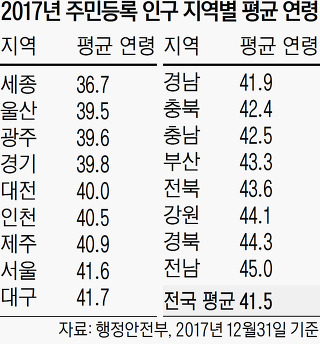

 - 전남과 경북이 평균연령이 매우 높은 편입니다.
 - 전남의 경우는 확진자 수가 매우 적어서 경북의 경우를 생각해보겠습니다.
 - 상대적으로 평균 연령이 높은 것이 사망률이 높은 것과 관련이 있는지 생각해볼 필요가 있을 것 같습니다.

# PatientInfo Data

### state( Isolated / Released / Deceased ) 중심의 EDA


- 1.1) 전체 state 비율
- 1.2) 연령대층에 따른 state 현황 
- 1.3) 성별에 따른 state 현황
- 1.4) State별 지역 환자 비율
- 1.5) 가장 높은 환자 비율의 지역들의 도시별 비율


- 2.1) 격리해제 환자(state=released)의 확진일(confirm date)과 격리해제 일(released date)까지의 소요 기간.
- 2.2) 사망 환자(state=deceased)의 확진일과 사망일 까지의 소요 기간.
-  cf) 격리 환자(state=isolated)는 격리가 진행중이기 때문에 released_date,deceased_date가 NaN.(제외) 
- 2.3) 연령층대별 평균이상 이하 소요기간


- 3.1) state에 따른 감염 경우 

In [17]:
p_info=pd.read_csv('PatientInfo.csv')

## 1.1) 전체 State 비율 

In [18]:
clr2 = [px.colors.sequential.Reds_r[3],
        px.colors.sequential.Reds_r[5],
        px.colors.sequential.Reds_r[1]]
total_state=pd.DataFrame(p_info['state'].value_counts()).reset_index()
fig=px.pie(total_state, values='state', names='index', title='<b>[격리자/ 격리해제자 / 사망]</b>', template = 'seaborn', color_discrete_sequence=clr2)
fig.update_traces(rotation=90, pull=0.05, textinfo="value+percent+label")
fig.show()

## 1.2) 연령대층에 따른 state 현황

In [19]:
state_age=p_info.groupby('state')['age'].value_counts()
stage_age=pd.DataFrame(state_age)

In [20]:
## 1.2) 연령대층에 따른 state 현황
#연령대 컬럼명 변경
stage_age.rename(index={'0s':'0대','10s':'10대','20s':'20대','30s':'30대','40s':'40대','50s':'50대','60s':'60대','70s':'70대','80s':'80대','90s':'90대','100s':'100대'},inplace=True)

stage_age=stage_age.T
stage_age=stage_age.drop(('isolated','100대'), axis=1, inplace=False) #격리된 연령층 100살대 1개 제외
stage_age=stage_age.T

stage_age.columns=['count']
released_=stage_age.loc['released',:].sort_index()
isolated=stage_age.loc['isolated',:].sort_index()
deceased=stage_age.loc['deceased',:].sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=released_.index, y=released_['count'],
                    mode='lines+markers',
                    name='격리해제 환자'))
fig.add_trace(go.Scatter(x=isolated.index, y=isolated['count'],
                    mode='lines+markers',
                    name='격리 환자'))
fig.add_trace(go.Scatter(x=deceased.index, y=deceased['count'], 
                    mode='lines+markers', name='사망 환자'))

fig.update_layout(title='[연령대층에 따른 상태]',
                   xaxis_title='연령대',
                   yaxis_title='환자 수')

fig.show()

#### 연령층별로 알아본 격리/ 격리해제/ 사망 상태

- 가장 많이 격리된 연령층도 20대 , 가장 많이 격리해제가 된 연령층도 20대
-  사망 연령층은 30대부터 시작, 80대가 가장 많음 

## 1.3) 성별에 따른 state

In [21]:
state_sex=pd.DataFrame(p_info.groupby('state')['sex'].value_counts())
state_sex

sex
state    sex        
deceased male     44
         female   23
isolated female  952
         male    743
released female  823
         male    615

In [22]:
state_sex.columns=['count']
state_sex=state_sex.reset_index()

fig=px.bar(state_sex, x='state', y='count', color='sex',title='state별 남/여 비율')
fig.show()

## 1.4) 지역별에 따른 State 현황

In [23]:
province_df=pd.DataFrame(p_info['province'].value_counts())
province_df=province_df.reset_index()
fig=px.pie(province_df, values='province', names='index', title='[전체 지역별 환자 수 및 비율(%)]', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [24]:
city_state=pd.DataFrame(p_info.groupby(['province','city'])['state'].value_counts())
city_state

state
province city        state          
Busan    Buk-gu      released      3
                     isolated      2
         Busanjin-gu isolated      8
                     released      3
                     deceased      2
...                              ...
Ulsan    Nam-gu      released     12
                     isolated      5
                     deceased      1
         Ulju-gun    isolated      2
                     released      2

[283 rows x 1 columns]

In [25]:
city_state=city_state.unstack()
city_state=city_state.fillna(0)
city_state

state                  
state                deceased isolated released
province city                                  
Busan    Buk-gu           0.0      2.0      3.0
         Busanjin-gu      2.0      8.0      3.0
         Dong-gu          0.0      1.0      0.0
         Dongnae-gu       0.0     11.0     22.0
         Gangseo-gu       0.0      0.0      3.0
...                       ...      ...      ...
Ulsan    Buk-gu           0.0      0.0      5.0
         Dong-gu          0.0      0.0      6.0
         Jung-gu          0.0      1.0      8.0
         Nam-gu           1.0      5.0     12.0
         Ulju-gun         0.0      2.0      2.0

[169 rows x 3 columns]

In [26]:
deceased=pd.DataFrame(city_state.loc[:,'state'].loc[:,'deceased']).reset_index()
isolated=pd.DataFrame(city_state.loc[:,'state'].loc[:,'isolated']).reset_index()
released=pd.DataFrame(city_state.loc[:,'state'].loc[:,'released']).reset_index()

### 지역별 "격리해제" 환자 수 및 비율 

In [27]:
fig=px.pie(released, values='released', names='province', title='[지역별 격리해제 환자 수 및 비율(%)]',color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### 지역별 "사망 환자" 수 및 비율

In [28]:
fig=px.pie(deceased, values='deceased', names='province', title='[지역별 사망 환자 수 및 비율(%)]',color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### 환자수가 가장 많은 상위 3개 지역 (경상북도, 경기도, 서울시)

#### 1위. 경상북도 

In [29]:
#가장 환자 수가 많았던 경상북도의 city별 state현황 : 경산시가 압도적으로 사망자 수, 격리자 수, 격리해제 수 많음.
city_state.loc['Gyeongsangbuk-do'].iplot(kind='barh', barmode="stack",title='[ 경상북도 시/군별 state 현황 ]')

#### 경상북도 현황
- 경산시(대구시 바로 옆)가 압도적. 격리해제자가 생각보다 495명으로 많다. 
- 신천지 교회가 있는 대구 남구 보다 대구 바로 옆인 경산시에 사망자, 격리자가 훨씬 많음. ?? 대구시에 대한 정보가 부족한듯하다. 대구 외부 데이터 사용해야 할듯하다.

#### 추가 ) 대구시

In [30]:
city_state.loc['Daegu'].iplot(kind='barh', barmode="stack",title='[ 대구광역시 구별 state 현황 ]')

#### 대구시
- 신천지 교회 소재지인 대구 남구에 사망자 1명, 격리자 7명 

#### 2위. 경기도 

In [31]:
city_state.loc['Gyeonggi-do'].iplot(kind='barh', barmode="stack",title='[ 경기도 시별 state 현황 ]')

#### 경기도 현황
- 경기도에는 성남시가 압도적으로 격리 환자 수(123명)가 많다.
- 사망자는 대체적으로 없고 남양주시에서만 1명 있다는 것 확인.
- 격리해제 환자도 대체적으로 거의 없음을 확인.  

#### 3위. 서울시 

In [32]:
city_state.loc['Seoul'].iplot(kind='barh', barmode="stack",title='[ 서울특별시 구별 state 현황 ]')

#### 서울 현황
- 강남구 : 격리자(46명), 격리해제자(13명)
- 관악구 : 격리자(26명) , 격리해제자(16명)
- 서초구 : 격리자(26명), 격리해제자(9명)
- 송파구 : 격리자(24명), 격리해제자(13명)
- 구로구 : 격리자(23명), 격리해제자(11명) + 구로구 콜센터 집단감염과 연관?.
- 동작구 : 격리자(23명), 격리해제자(7명)
- 마포구 : 유일한 사망자: 1명, 격리자(13명), 격리해제자(8명)
.
.


## 2.1) 격리해제 환자(state=released)의 확진일(confirm date)과 격리해제 일(released date)까지의 소요 기간. 

In [33]:
released_p=p_info[p_info['state']=='released']
#격리해제자인데 격리해제된날 NaN인 사람 : 304명 제외 => drop
released_p=released_p.dropna(subset=['released_date'], inplace=False)

In [34]:
import re

confirm_list=[]
released_list=[]

for date in released_p['confirmed_date']:
    r= re.compile('(?P<year>\d+)[-](?P<month>\d+)[-](?P<date>\d+)')
    confirm_list.append(r.sub('\g<year>\g<month>\g<date>',date))

for date in released_p['released_date']:
    r= re.compile('(?P<year>\d+)[-](?P<month>\d+)[-](?P<date>\d+)')
    released_list.append(r.sub('\g<year>\g<month>\g<date>',date))

released_p['confirmed_date']=confirm_list 
released_p['released_date']=released_list

released_p['confirmed_date']=released_p['confirmed_date'].astype(int)
released_p['released_date']=released_p['released_date'].astype(int)

released_p['period_diff']=released_p['released_date']-released_p['confirmed_date']
released_p['period_diff'].describe() 

count    1135.000000
mean       65.717181
std        45.785985
min         0.000000
25%        19.000000
50%        85.000000
75%        97.000000
max       190.000000
Name: period_diff, dtype: float64

### 결과 

- 평균: 65.7일
- 최대: 190일
- 최소: 0일? 만에 격리해제 

In [35]:
deceased_p=p_info[p_info['state']=='deceased']
deceased_p=deceased_p.dropna(subset=['deceased_date'], inplace=False)

In [36]:
#0일만에 격리해제된 사람: 20대 남성(97년생, 경기도 수원시, 환자와의 접촉)
released_p[released_p['period_diff']==0]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,period_diff
1128,2000000092,4384.0,male,1997.0,20s,Korea,Gyeonggi-do,Suwon-si,NaN,contact with patient,NaN,2.000000e+09,NaN,NaN,20200302,20200302,NaN,released,0


In [37]:
#최대일수 190일만에 격리해제된 사람: 20대 여성(91년생, 경산시, 신천지교회에서 감염) 
released_p[released_p['period_diff']==190]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,period_diff
1923,6001000001,67.0,female,1991.0,20s,Korea,Gyeongsangbuk-do,Gyeongsan-si,NaN,Shincheonji Church,NaN,1.200000e+09,7.0,NaN,20200219,20200409,NaN,released,190


## 2.2) 사망자(state=deceased)의 확진일과 사망일 까지의 소요 기간

In [38]:
deceased_p=p_info[p_info['state']=='deceased']
deceased_p=deceased_p.dropna(subset=['deceased_date'], inplace=False)

confirm_list=[]
released_list=[]

for date in deceased_p['confirmed_date']:
    r= re.compile('(?P<year>\d+)[-](?P<month>\d+)[-](?P<date>\d+)')
    confirm_list.append(r.sub('\g<year>\g<month>\g<date>',date))

for date in deceased_p['deceased_date']:
    r= re.compile('(?P<year>\d+)[-](?P<month>\d+)[-](?P<date>\d+)')
    released_list.append(r.sub('\g<year>\g<month>\g<date>',date))

deceased_p['confirmed_date']=confirm_list 
deceased_p['deceased_date']=released_list

deceased_p['confirmed_date']=deceased_p['confirmed_date'].astype(int)
deceased_p['deceased_date']=deceased_p['deceased_date'].astype(int)

deceased_p['period_diff']=deceased_p['deceased_date']-deceased_p['confirmed_date']
deceased_p['period_diff'].describe()

count     60.000000
mean      37.450000
std       46.381405
min       -1.000000
25%        2.000000
50%        9.000000
75%       77.000000
max      188.000000
Name: period_diff, dtype: float64

In [39]:
deceased_p[deceased_p['period_diff']==-1] 
#청도대남병원에서 사후판정 2명 사망자 : 질병여부 0, 청도대남병원에서 사망. => 신천지 발생 이후 사망, 청도대남병원으로 확진자들 대거 유입되면서 걸렸을 수 있겠음. 

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,period_diff
3018,6020100104,104.0,male,1957.0,60s,Korea,Gyeongsangbuk-do,Cheongdo-gun,True,Cheongdo Daenam Hospital,NaN,NaN,NaN,NaN,20200220,NaN,20200219,deceased,-1
3020,6020100205,205.0,female,1965.0,50s,Korea,Gyeongsangbuk-do,Cheongdo-gun,True,Cheongdo Daenam Hospital,NaN,NaN,NaN,NaN,20200222,NaN,20200221,deceased,-1


In [40]:
deceased_p[deceased_p['patient_id']==6020100104]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,period_diff
3018,6020100104,104.0,male,1957.0,60s,Korea,Gyeongsangbuk-do,Cheongdo-gun,True,Cheongdo Daenam Hospital,NaN,NaN,NaN,NaN,20200220,NaN,20200219,deceased,-1


## 2.3) 연령층대별 평균이상 이하 소요기간

#### 평균 66일을 기준으로 평균이상, 이하인 환자들로 나누어 더 자세히 알아보았습니다.

In [41]:
released_p['over_aveg']=np.where(released_p['period_diff']>66,1,0)
over_av_released=released_p[released_p['over_aveg']==1]
under_av_released=released_p[released_p['over_aveg']==0]

over_av=pd.DataFrame(over_av_released['age'].value_counts().sort_index()).reset_index()
under_av=pd.DataFrame(under_av_released['age'].value_counts().sort_index()).reset_index()

#연령대층별로 감염자수가 확연히 다르기때문에 각 연령층별의 비율로 계산

under_av['per']=under_av['age']/(under_av['age']+over_av['age']) 
over_av['per']=over_av['age']/(under_av['age']+over_av['age'])

#컬럼 재정리
under_av.columns=['age', 'count', 'per']
over_av.columns=['age', 'count', 'per']

In [42]:
fig=px.pie(over_av, values='count', names='age', title='[연령대별 확진날짜~격리해제 소요기간 (평균이상)]', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(rotation=90, pull=0.05, textinfo="value+percent+label")
fig.show()

In [43]:
fig=px.pie(under_av, values='count', names='age', title='[연령대별 확진날짜~격리해제 소요기간 (평균이하)]', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(rotation=90, pull=0.05, textinfo="value+percent+label")
fig.show()

#### 결과 
- 10대,20대,30대 들도 격리해제까지 걸리는 평균 기간 66일 이상이 60%를 넘는것을 보아 COVID-19는 쉽게 완치되지 않는 병임을 알 수 있었다.
- 평균일수를 넘는 비율이 가장 큰 연령층은 60대이며, 70%가 넘는다.

## 3.1) 감염 케이스에 따른 State 

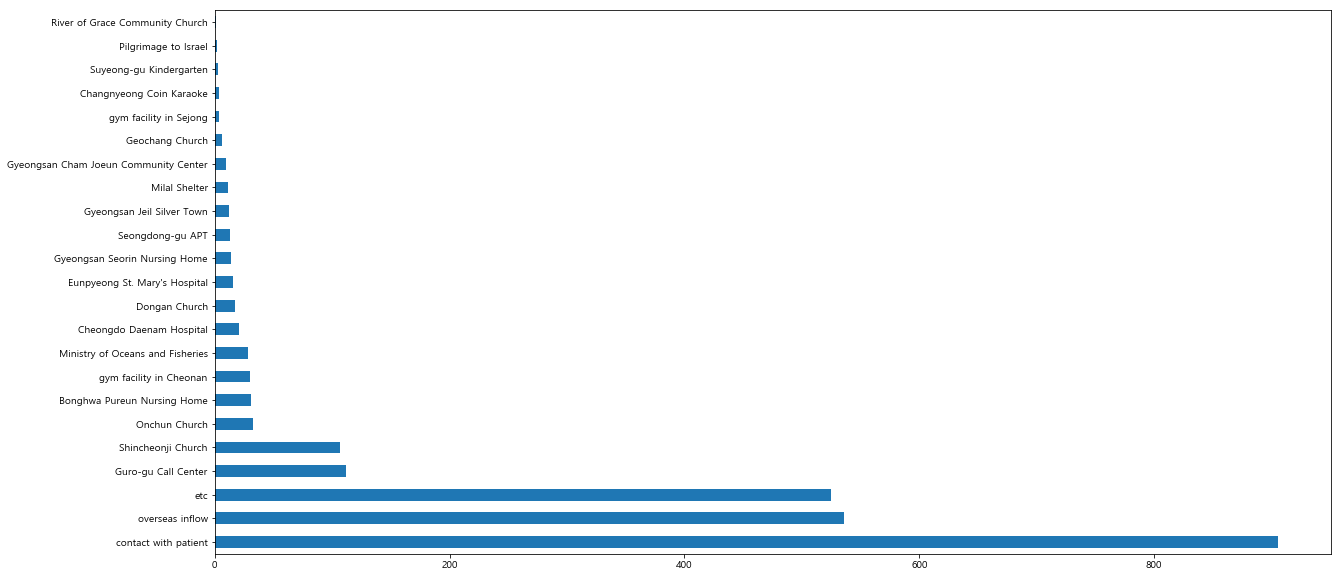

In [44]:
p_info['infection_case'].value_counts().plot.barh(figsize=(20,10))
#환자끼리와의 접촉이 가장 많음

In [45]:
case_state=pd.DataFrame(p_info.groupby('infection_case')['state'].value_counts())
case_state=case_state.unstack(level=0)
case_state.iplot(kind='barh', barmode="stack",title='state별 감염 케이스')

In [46]:
#격리해제자 수/격리자 수/사망자 수 가장 많은 감염 경우 부터
p_info.groupby('infection_case')['state'].value_counts().sort_values(ascending=False)

infection_case                         state   
contact with patient                   isolated    582
overseas inflow                        isolated    469
contact with patient                   released    320
etc                                    isolated    262
                                       released    250
Shincheonji Church                     released     69
overseas inflow                        released     67
Guro-gu Call Center                    released     58
                                       isolated     53
Shincheonji Church                     isolated     36
Bonghwa Pureun Nursing Home            isolated     30
Onchun Church                          released     28
gym facility in Cheonan                released     25
Ministry of Oceans and Fisheries       isolated     16
Cheongdo Daenam Hospital               isolated     13
etc                                    deceased     13
Ministry of Oceans and Fisheries       released     12
Seongdong-gu APT 

#### 감염 케이스

- 격리해제자 : 다른환자와의 접촉(320명) > 기타(250명) > 신천지교회(69명) > 구로콜센터(58명) > 온천교회(28명) > 천안 체육관(25명) > ...

- 격리자 : 다른환자와의 접촉(582명) >  해외(469명) > 기타(262명) > 구로콜센터(53명) > 신천지교회(36명) > 봉화푸른요양원(30명) > ..

- 사망자 : 기타(13명) > 청도대남병원(7명) > 다른 환자와의 접촉(3명) > 신천지교회(2명) > 구로콜센터(1명) ..


- 결론: 다른환자와의 접촉 사례가 가장 큼, 최근 해외에서 온 격리자 수가 많아졌음을 알 수 있다.

# Route data


- 환자 이동장소 유형
- 확진자별 이동경로

In [47]:
route=pd.read_csv('PatientRoute.csv')
route['patient_id'].value_counts() #총 939명의 환자의 동선

3009000014    42
1400000021    38
3009000013    37
1100000069    35
3009000003    33
              ..
6100000082     1
6020100107     1
1100000062     1
1400000012     1
6023000044     1
Name: patient_id, Length: 939, dtype: int64

## 1) 환자 이동 장소 유형 

In [48]:
type_infection=pd.DataFrame(route['type'].value_counts())
type_infection=type_infection.reset_index()

fig=px.pie(type_infection, values='type', names='index', title='[환자 이동 장소 유형 수 및 비율(%)]')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

#### 감염자가 이동한 장소 

- 기타가 제일 높은 비율 차지. 기타가 뭘지일지는 외부데이터를 사용하여 두번째 Search Insight 로 분석 예정.
- 기타와 병원이 60%로 대부분의 비율 차지.

## 2) 확진자별 이동경로 

In [49]:
#확진자가 방문한 위치 분포를 알아보기 위해 scatter형태로 표시

fig_map = px.scatter_mapbox(route, lat="latitude", lon="longitude",
                color_continuous_scale="Rainbow", size_max=50)
fig_map.update_layout(mapbox_style="carto-positron",width=900, height=700)
fig_map.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig_map.show()

# Case data 

- 위치별 확진 환자 수 분포

### 1) 위치별 확진 환자 수 분포   

In [50]:
case=pd.read_csv('Case.csv')

case[['latitude','longitude']]=np.where(case[['latitude','longitude']]=='-',None,case[['latitude','longitude']])
case[['latitude','longitude']]=case[['latitude','longitude']].astype(float)

fig_map = px.scatter_mapbox(case, lat="latitude", lon="longitude", color='case_id',
                color_continuous_scale="Rainbow", size='confirmed', size_max=50, zoom=7)
fig_map.update_layout(mapbox_style="carto-positron",width=900, height=700)
fig_map.update_layout(margin={"r":0,"t":0,"l":0,"b":0}) #margin(layout 크기) 맞춤
fig_map.show()

# SearchTrend

- 1.1) 날짜에 따른 검색량 변화

In [52]:
searchTrend = pd.read_csv("SearchTrend.csv")
searchTrend.head()

,date,cold,flu,pneumonia,coronavirus
0,2016-01-01,0.11663,0.05590,0.15726,0.00736
1,2016-01-02,0.13372,0.17135,0.20826,0.00890
2,2016-01-03,0.14917,0.22317,0.19326,0.00845
3,2016-01-04,0.17463,0.18626,0.29008,0.01145
4,2016-01-05,0.17226,0.15072,0.24562,0.01381


## 1.1) 날짜에 따른 검색어 검색량

In [53]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=searchTrend['date'],y= searchTrend['cold'],  
             mode='lines+markers', name='cold'))
fig.add_trace(go.Scatter(x=searchTrend['date'],y= searchTrend['flu'],  
             mode='lines+markers', name='flu'))
fig.add_trace(go.Scatter(x=searchTrend['date'],y= searchTrend['pneumonia'],  
             mode='lines+markers', name='pneumonia'))
fig.add_trace(go.Scatter(x=searchTrend['date'],y= searchTrend['coronavirus'],  
             mode='lines+markers', name='coronavirus'))

fig.update_layout(title='<b>시간에 따른 검색어 트랜드</b>',
                   xaxis_title='Month',
                   yaxis_title='Percentage',
                 font=dict(size=18,color='#60606e',family='Franklin Gothic' ))
fig.show()

##### 2016년 12월 'flu' 검색량 증가
- 원인 : 독감 유행

##### 2019년 3월  'cold' 검색량 증가
- 원인 : 감기 유행

##### 2020년 1월 8일 폐렴 검색 증가
 
##### 2020년 1월 20일 코로나 검색 증가
- 원인 : 첫 확진자 발생
 
#####  2020년 2월 18일 코로나 검색 다시 급증 
- 원인 : 31번 확진자 발생

# Seoul Floating

- 1.1) birth_year에 따른 유동인구 조사
- 1.2) 성별에 따른 유동인구 조사
- 1.3) 시간에 따른 유동인구 조사

In [54]:
seoulFloating = pd.read_csv("SeoulFloating.csv")
seoulFloating.head()

,date,hour,birth_year,sex,province,city,fp_num
0,2020-01-01,0,20,female,Seoul,Dobong-gu,19140
1,2020-01-01,0,20,male,Seoul,Dobong-gu,19950
2,2020-01-01,0,20,female,Seoul,Dongdaemun-gu,25450
3,2020-01-01,0,20,male,Seoul,Dongdaemun-gu,27050
4,2020-01-01,0,20,female,Seoul,Dongjag-gu,28880


## 1.1) birth_year에 따른 유동 인구 조사

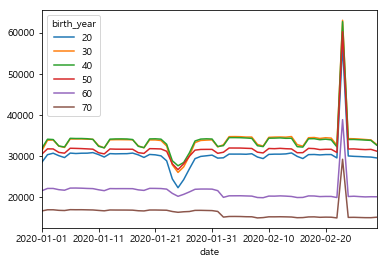

In [55]:
pd.pivot_table(seoulFloating, index='date',columns='birth_year',values='fp_num').plot()

30,40대 > 50대 > 20대 > 60대 > 70대

### 1.1.1) 구별 birth_year에 따른 유동 인구 조사

In [56]:
city_names = set(seoulFloating.city)
for name in city_names:
    city = seoulFloating[seoulFloating.city==name]
    
    city = pd.pivot_table(city,index='date',columns='birth_year',values='fp_num')
    
    fig = go.Figure() 
    fig.add_trace(go.Scatter(x=city.index,y= city[70], 
             mode='lines+markers', name='70'))
    fig.add_trace(go.Scatter(x=city.index,y= city[60], 
             mode='lines+markers', name='60'))
    fig.add_trace(go.Scatter(x=city.index,y= city[50], 
             mode='lines+markers', name='50'))
    fig.add_trace(go.Scatter(x=city.index,y= city[40],
             mode='lines+markers', name='40'))
    fig.add_trace(go.Scatter(x=city.index,y= city[30],
             mode='lines+markers', name='30'))
    fig.add_trace(go.Scatter(x=city.index,y= city[20],
             mode='lines+markers', name='20'))
    
    fig.update_layout(title= name,
                   xaxis_title='Date',
                   yaxis_title='Number',
                 font=dict(size=18,color='#60606e',family='Franklin Gothic' ))
    fig.show()

## 1.2) 성별에 따른 유동 인구 조사

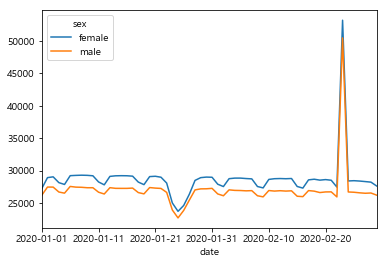

In [57]:
pd.pivot_table(seoulFloating, index='date',columns='sex',values='fp_num').plot()

### 1.2.1) 구별 성별에 따른 유동 인구 조사

In [58]:
for name in city_names:
    city = seoulFloating[seoulFloating.city==name]
    
    city = pd.pivot_table(city,index='date',columns='sex',values='fp_num')
    
    fig = go.Figure() 
    fig.add_trace(go.Scatter(x=city.index,y= city['female'], 
             mode='lines+markers', name='female'))
    fig.add_trace(go.Scatter(x=city.index,y= city['male'],
             mode='lines+markers', name='male'))
    
    fig.update_layout(title= name,
                   xaxis_title='Date',
                   yaxis_title='Number',
                 font=dict(size=18,color='#60606e',family='Franklin Gothic' ))
    fig.show()

- 1/24 - 1/25 감소 : 24일에 2번째 확진자 나옴

- 2/23 증가 : 구정(설) 시작

## 1.3) 시간에 따른 유동인구 조사

In [59]:
hour_fp=pd.DataFrame()
for day in set(seoulFloating.date):
    hour_fp[day] = pd.pivot_table(seoulFloating, 
                                  index='hour',columns='date',values='fp_num').sort_values(by=[day],ascending=False).index

hour_fp = hour_fp.reindex(sorted(hour_fp.columns), axis=1).T
for i in range(24):
    print(hour_fp[i].value_counts().index[0],end=" ")

14 15 13 16 17 12 11 10 18 9 8 19 20 21 7 22 23 0 1 6 2 3 5 4 

### 1.3.1) 구별 시간에 따른 유동인구 조사

In [60]:

for name in set(seoulFloating.city):
    print('='*30,name,'='*30)
    city = seoulFloating[seoulFloating.city==name]
    hour_fp=pd.DataFrame()
    for day in set(city.date):
        hour_fp[day] = pd.pivot_table(city, 
                                      index='hour',columns='date',values='fp_num').sort_values(by=[day],ascending=False).index

    hour_fp = hour_fp.reindex(sorted(hour_fp.columns), axis=1).T
    for i in range(24):
        print(hour_fp[i].value_counts().index[0],end=" ")
    print("\n"*2)

============================== Gangbuk-gu ==============================
0 1 2 3 23 4 22 5 21 20 20 19 7 18 8 17 9 16 10 15 11 12 14 13 


============================== Jongno-gu ==============================
13 14 12 15 11 16 10 17 9 8 18 19 20 7 21 22 6 23 5 0 1 4 2 3 


============================== Gwanak-gu ==============================
2 1 0 3 4 23 5 22 6 21 20 7 19 18 8 17 9 16 10 15 11 12 14 13 


============================== Yeongdeungpo-gu ==============================
13 14 12 15 11 10 16 9 17 8 18 7 19 20 21 6 22 23 5 0 1 2 2 3 


============================== Gangdong-gu ==============================
1 2 2 3 4 5 5 6 22 21 20 7 19 18 8 17 9 10 16 11 15 14 14 13 


============================== Songpa-gu ==============================
18 19 17 17 15 20 21 15 23 14 13 12 11 10 11 7 0 1 1 2 6 5 5 4 


============================== Dongjag-gu ==============================
7 22 1 2 1 0 6 5 3 4 21 20 19 18 8 17 9 16 10 15 15 13 13 12 


============================== 

# Region

### 지역(province,city) 중심의 EDA

- 1.1) province에 따른 학교 비율
- 1.2) province에 따른 학원 비율
- 1.3) province에 따른 노인 비율과 독거노인의 비율
- 1.4) province에 따른 양로원 비율
- 1.5) province의 city에 따른 학교,학원,노인,독거노인,양로원 비율


In [61]:
Region = pd.read_csv("Region.csv")
Region.head()

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,Seoul,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
1,10010,Seoul,Gangnam-gu,37.518421,127.047222,33,38,0,4.18,13.17,4.3,3088
2,10020,Seoul,Gangdong-gu,37.530492,127.123837,27,32,0,1.54,14.55,5.4,1023
3,10030,Seoul,Gangbuk-gu,37.639938,127.025508,14,21,0,0.67,19.49,8.5,628
4,10040,Seoul,Gangseo-gu,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080


In [63]:
province_names = list(set(Region.province))
print("procine개수는 {}개 입니다.".format(len(province_names)))
city_names = list(set(Region.city))
print("city개수는 {}개 입니다.".format(len(city_names)))

procine개수는 18개 입니다.
city개수는 222개 입니다.


#### 한국 전체

In [64]:
Region_korea = Region[Region.province == 'Korea']
Region_korea

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
243,80000,Korea,Korea,37.566953,126.977977,6087,8837,340,1.56,15.67,7.2,94865


#### 도(시) 별

In [65]:
Region_total = Region[Region.province == Region.city]
Region_total.set_index('city', drop=True, inplace=True)
Region_total.drop('Korea',inplace=True, axis=0)
Region_total

,code,province,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
city,,,,,,,,,,,
Seoul,10000,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
Busan,11000,Busan,35.179884,129.074796,304,408,22,1.40,18.41,8.6,6752
Daegu,12000,Daegu,35.872150,128.601783,229,355,11,1.62,15.78,7.5,5083
Gwangju,13000,Gwangju,35.160467,126.851392,155,312,17,2.38,13.57,6.4,2852
Incheon,14000,Incheon,37.456188,126.705920,250,403,7,1.27,13.20,5.8,4497
Daejeon,15000,Daejeon,36.350621,127.384744,148,260,15,1.49,13.65,5.8,2984
Ulsan,16000,Ulsan,35.539797,129.311538,119,200,4,2.21,11.76,5.2,1801
Sejong,17000,Sejong,36.480132,127.289021,48,60,3,1.78,9.48,3.8,491
Gyeonggi-do,20000,Gyeonggi-do,37.275119,127.009466,1277,2237,61,1.60,12.63,5.2,20491


In [66]:
# 각 도(시)마다 구 개수 
for province in Region_total.province:
    print(province, Region[Region.province==province].shape[0])

Seoul 26
Busan 17
Daegu 9
Gwangju 6
Incheon 11
Daejeon 6
Ulsan 6
Sejong 1
Gyeonggi-do 32
Gangwon-do 19
Chungcheongbuk-do 12
Chungcheongnam-do 16
Jeollabuk-do 15
Jeollanam-do 23
Gyeongsangbuk-do 24
Gyeongsangnam-do 19
Jeju-do 1


## 1.1) province에 따른 학교 수

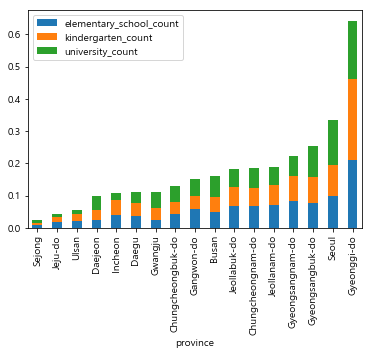

In [67]:
school_name = ["elementary_school_count","kindergarten_count","university_count"]
school = Region_total[school_name]
school = school/Region_korea[school_name].values # 수를 비율로 변경
school["sum"] = school.sum(axis=1)
school['province'] = Region_total.province
school = school.sort_values(by='sum')
school.set_index("province",drop=True, inplace=True)
school.drop(['sum'],axis=1,inplace=True)

school_ax = school.plot(kind='bar',stacked='True')
plt.legend(loc="upper left")
plt.show()

## 1.2) province에 따른 학원 비율

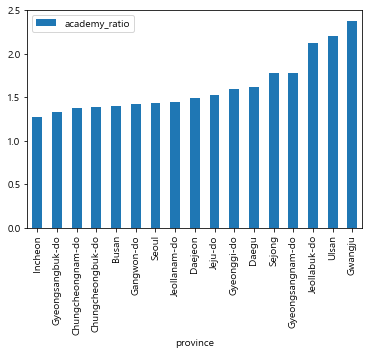

In [68]:
academy = Region_total[['academy_ratio','province']]
academy = academy.sort_values('academy_ratio').reset_index(drop=True)
academy.set_index("province",drop=True, inplace=True)

academy.plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

## 1.3) province에 따른 노인 인구 비율과 독거노인의 비율

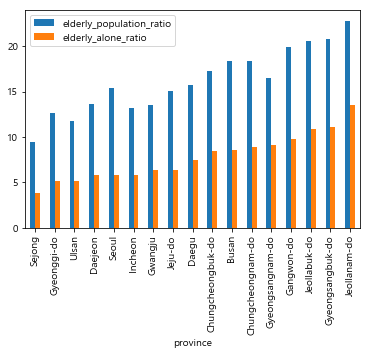

In [69]:
elderly = Region_total[['elderly_population_ratio','elderly_alone_ratio']]
elderly.set_index(Region_total.province,inplace=True)
elderly.sort_values(by='elderly_alone_ratio',inplace=True)
elderly.plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

## 1.4) province에 따른 양로원 수

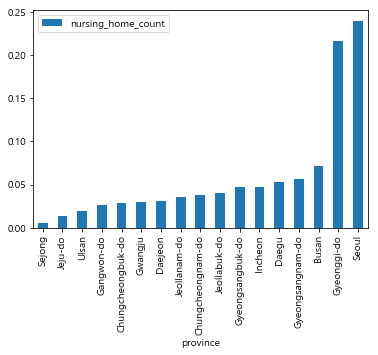

In [70]:
nursing = Region_total[['nursing_home_count','province']]
nursing['nursing_home_count'] = nursing['nursing_home_count']/Region_korea['nursing_home_count'].values
nursing = nursing.sort_values('nursing_home_count').reset_index(drop=True)
nursing.set_index("province",drop=True, inplace=True)

nursing.plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

## 1.5) province의 city에 따라 

In [71]:
def city_df(city_name):
    city = Region[(Region.province==city_name)&(Region.city!=city_name)]
    province = Region[(Region.province==city_name) & (Region.city == city_name)]
    
    school_name = ['kindergarten_count','elementary_school_count','university_count']
    city['kindergarten_ratio'] = city[school_name[0]].values/province[school_name[0]].values
    city['elementary_school_ratio'] = city[school_name[1]].values/province[school_name[1]].values
    city['university_ratio'] = city[school_name[2]].values/province[school_name[2]].values
    city['nursing_home_ratio'] = city['nursing_home_count']/province['nursing_home_count'].values
    return city

def school_graph(name):
    df = city_df(name)
    school = df[["elementary_school_ratio","kindergarten_ratio","university_ratio"]]
    school["sum"] = school.sum(axis=1)
    school['city'] = df.city
    school = school.sort_values(by='sum')
    school.set_index("city",drop=True, inplace=True)
    school.drop(['sum'],axis=1,inplace=True)

    school_ax = school.plot(kind='bar',stacked='True')
    plt.legend(loc="upper left")
    plt.show()

def academy_graph(name):
    df = city_df(name)
    academy = df[['academy_ratio','city']]
    academy = academy.sort_values('academy_ratio').reset_index(drop=True)
    academy.set_index("city",drop=True, inplace=True)
    academy.plot(kind='bar')
    plt.xticks(rotation=90)
    plt.show()

def nursing_grapy(name):
    df = city_df(name)
    nursing = df[['nursing_home_ratio','city']]
    nursing = nursing.sort_values('nursing_home_ratio').reset_index(drop=True)
    nursing.set_index("city",drop=True, inplace=True)
    nursing.plot(kind='bar')
    plt.xticks(rotation=90)
    plt.show()

def elderly_graph(name):
    df = city_df(name)
    elderly = df[['elderly_population_ratio','elderly_alone_ratio']]
    elderly.set_index(df.city,inplace=True)
    elderly.sort_values(by='elderly_alone_ratio',inplace=True)
    elderly.plot(kind='bar')
    plt.xticks(rotation=90)
    plt.show()

def all_graph(name):
    school_graph(name)
    academy_graph(name)
    nursing_grapy(name)
    elderly_graph(name)

#### Seoul

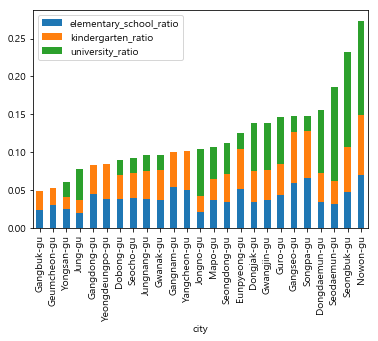

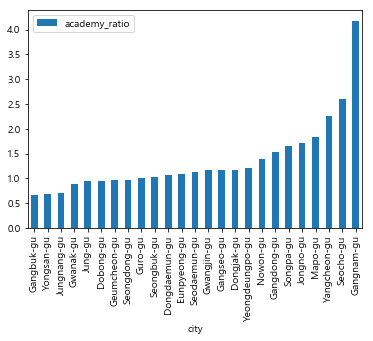

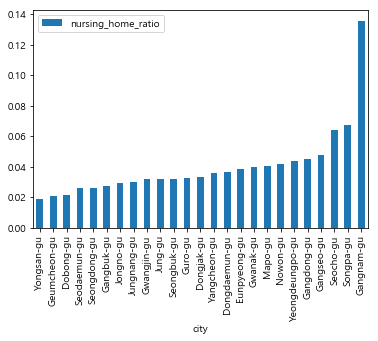

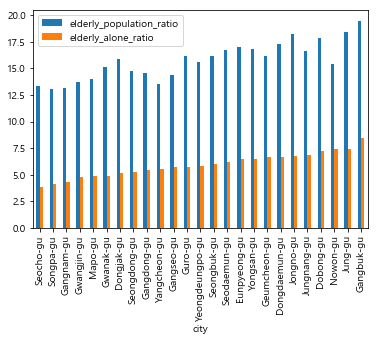

In [72]:
all_graph("Seoul")

#### Jeollabuk-do

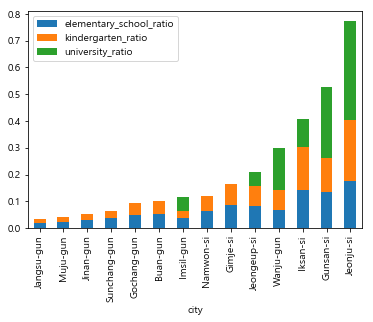

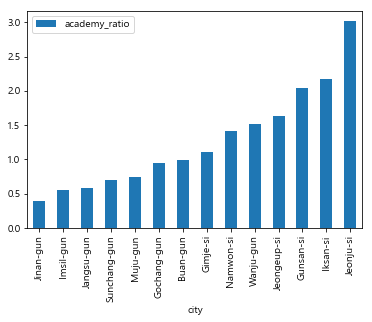

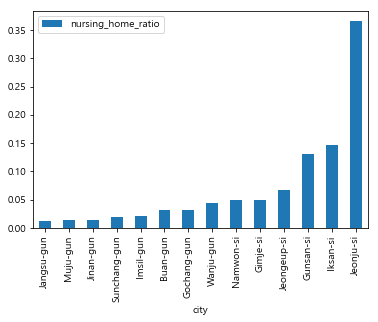

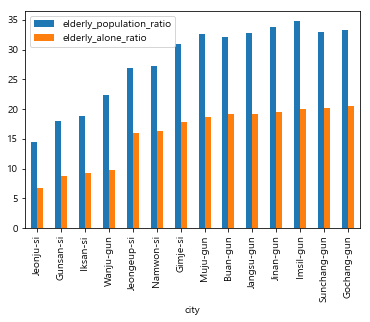

In [73]:
all_graph("Jeollabuk-do")

#### Gangwon-do

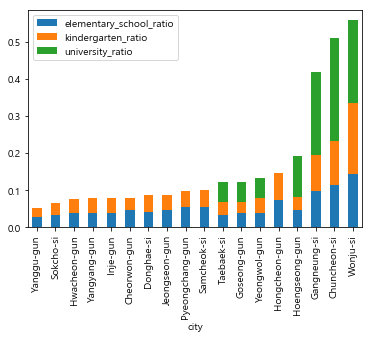

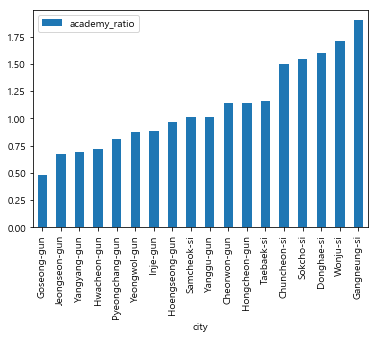

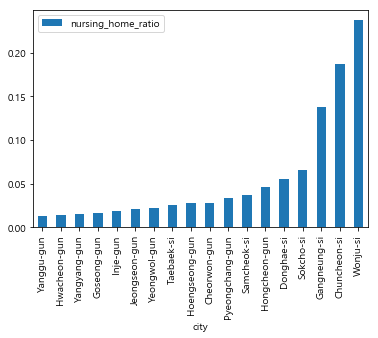

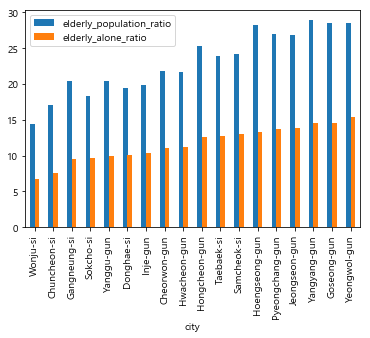

In [74]:
all_graph("Gangwon-do")

#### Gyeongsangbuk-do

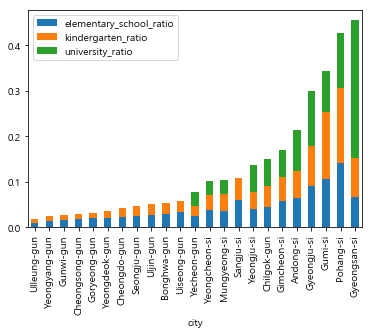

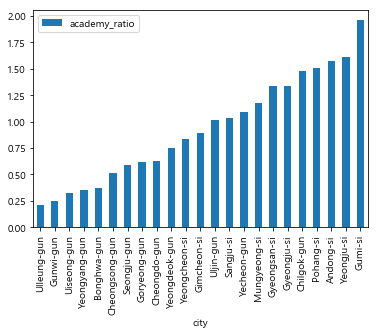

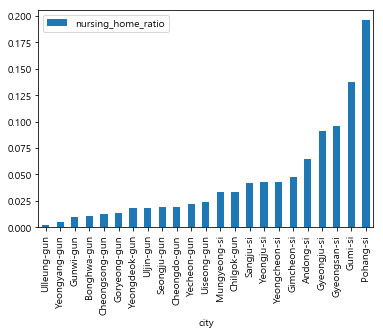

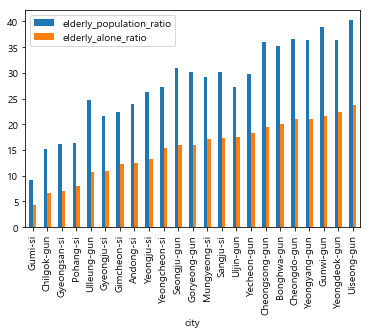

In [75]:
all_graph("Gyeongsangbuk-do")

#### Incheon

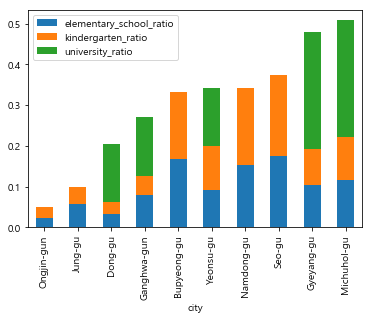

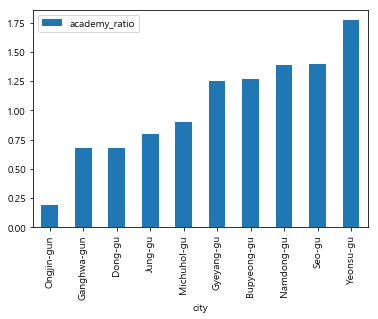

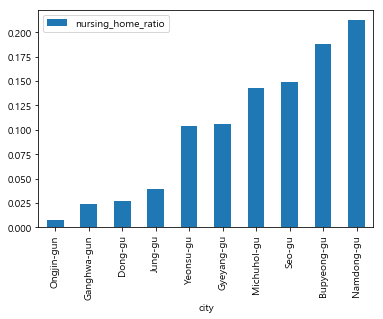

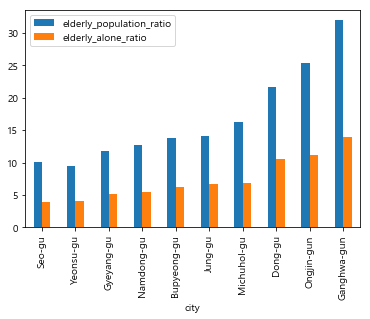

In [76]:
all_graph("Incheon")

#### Daegu

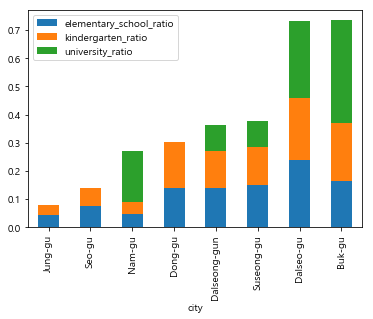

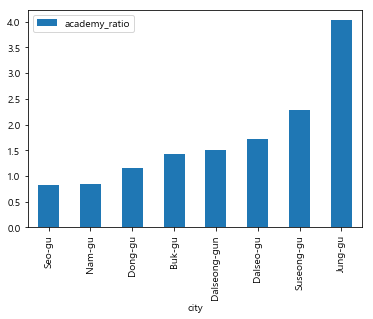

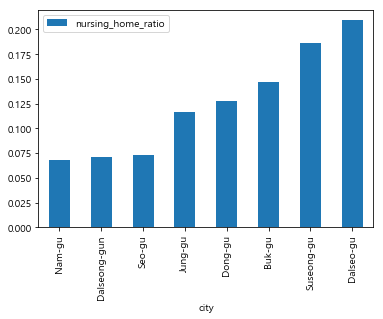

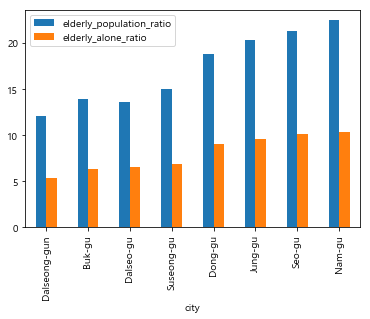

In [77]:
all_graph("Daegu")

#### Chungcheongnam-do

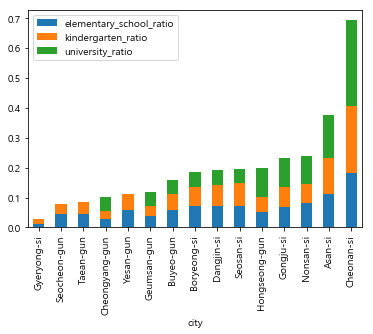

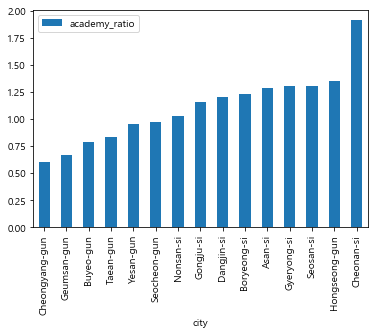

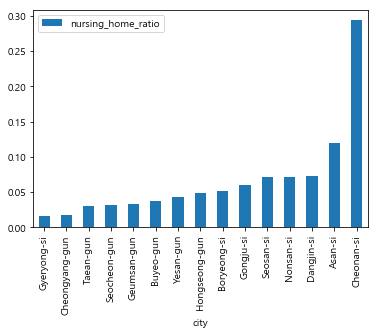

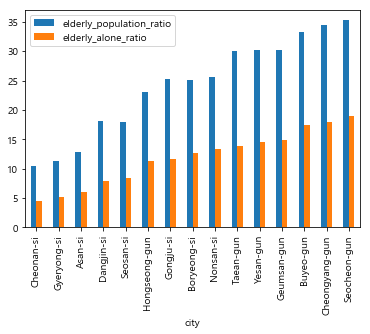

In [78]:
all_graph("Chungcheongnam-do")

#### Daejeon

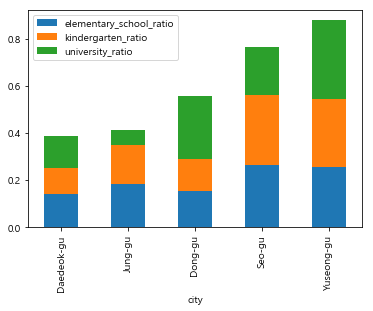

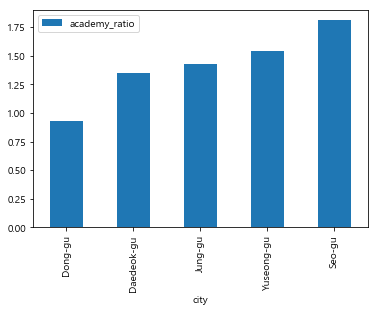

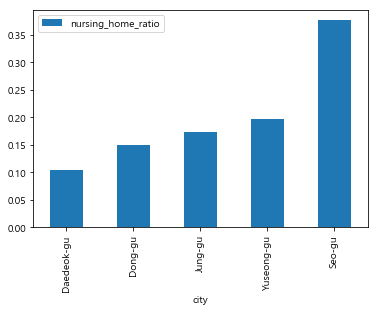

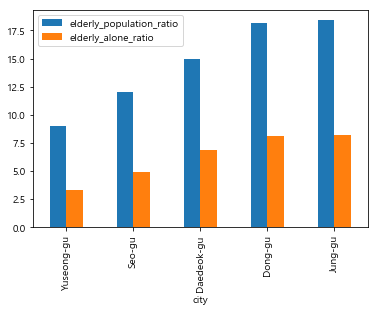

In [79]:
all_graph("Daejeon")

#### Chungcheongbuk-do

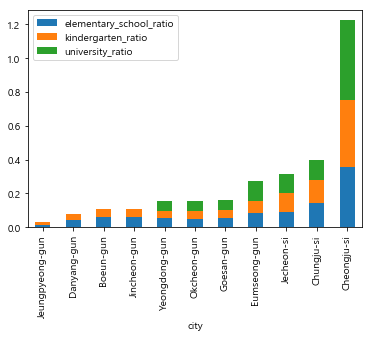

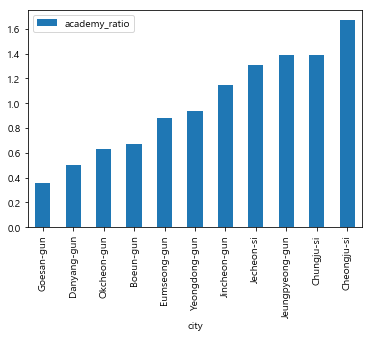

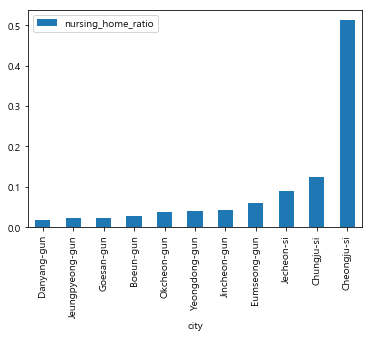

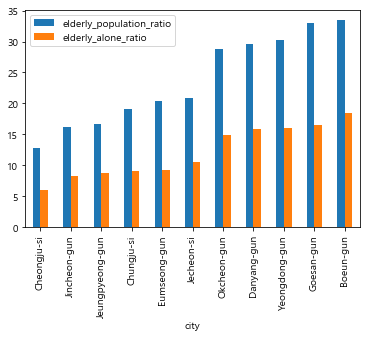

In [82]:
all_graph("Chungcheongbuk-do")

#### Busan

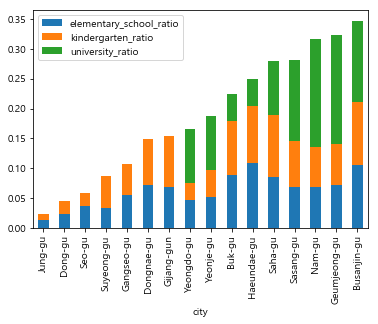

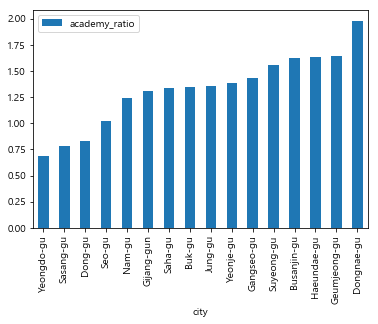

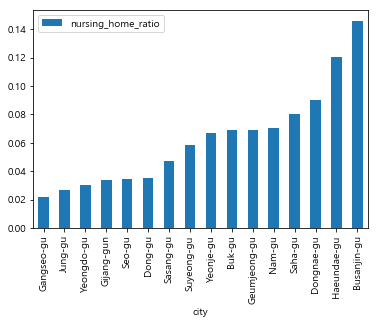

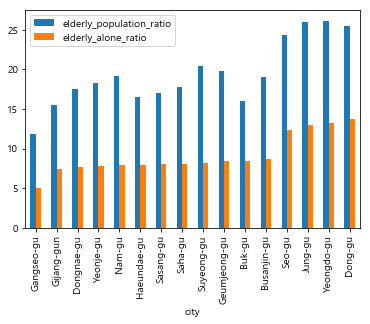

In [83]:
all_graph("Busan")

#### Gyeongsangnam-do

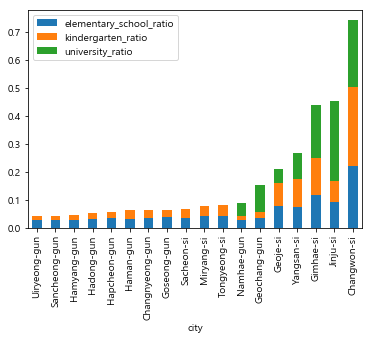

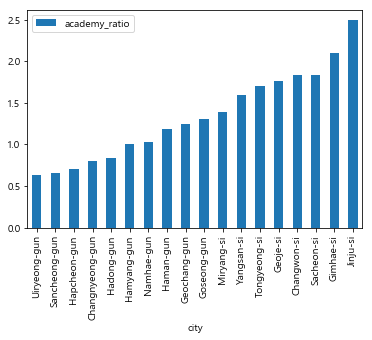

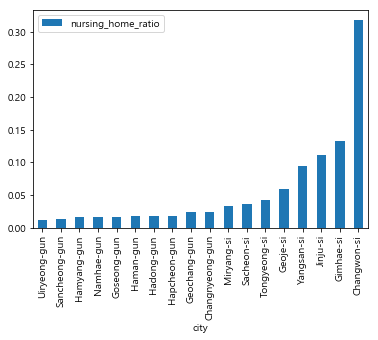

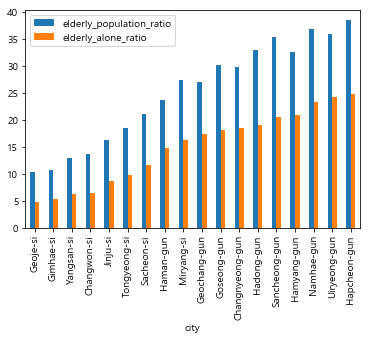

In [84]:
all_graph("Gyeongsangnam-do")

#### Jeollanam-do

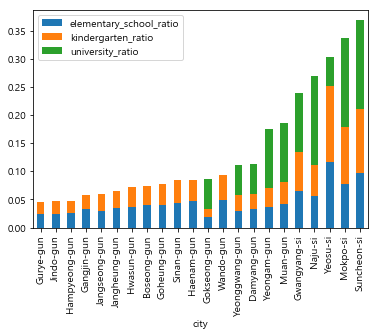

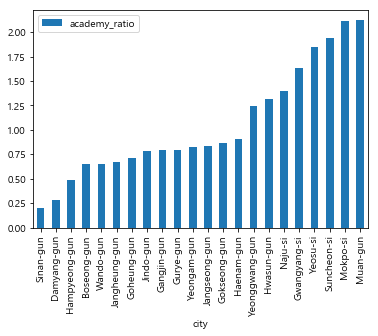

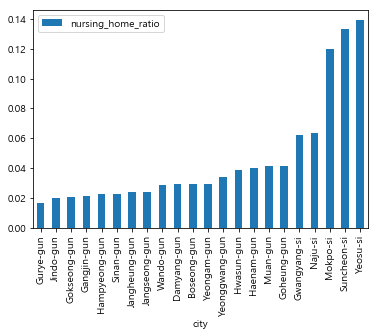

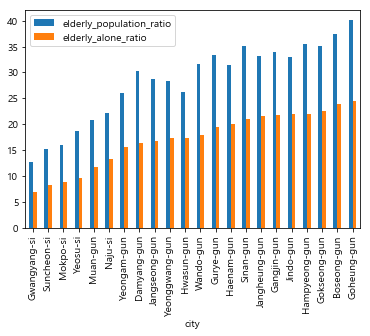

In [85]:
all_graph("Jeollanam-do")

#### Gwangju

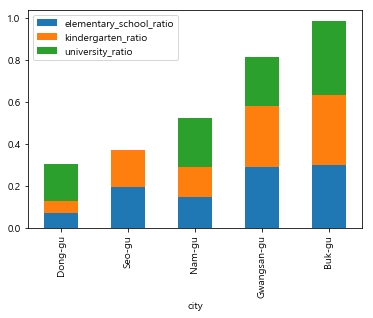

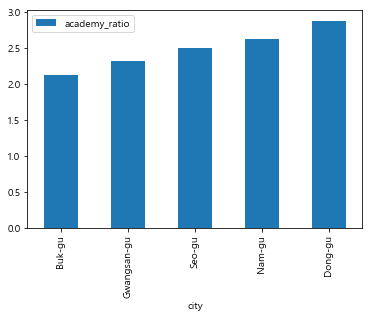

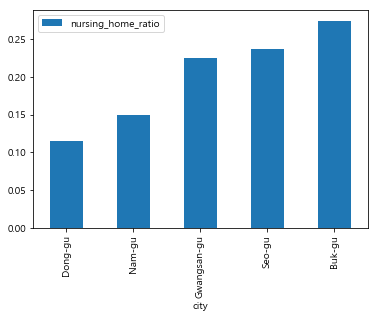

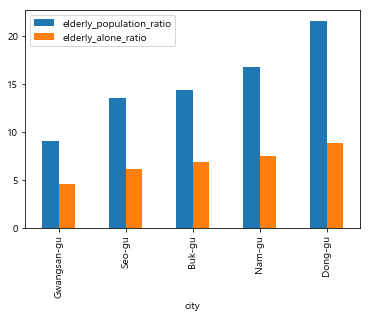

In [86]:
all_graph("Gwangju")

#### Ulsan

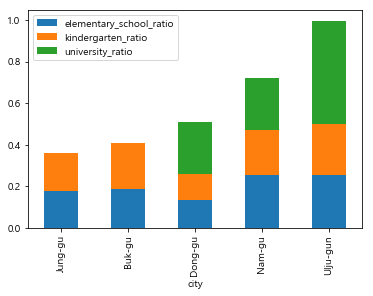

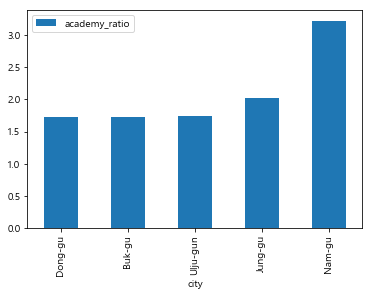

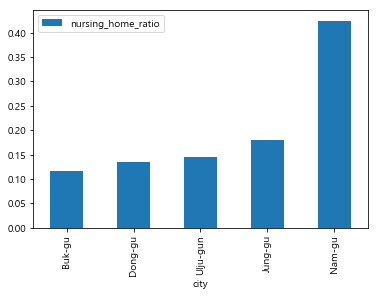

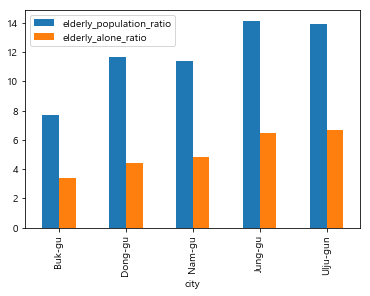

In [88]:
all_graph("Ulsan")

In [90]:
fig_map = px.scatter_mapbox(Region_total, lat='latitude',lon='longitude',
                            color_continuous_scale='Rainbow', size_max=50, zoom=7,
                           hover_data=['elementary_school_count', 'kindergarten_count', 'university_count'])
fig_map.update_layout(mapbox_style='carto-positron',width=900, height=700)
fig_map.update_layout(margin={"r":0,'t':0,'l':0,'b':0})
fig_map.show()